In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from classifier import *
from ntk import *
from Q_minimization import *

### Define Dataset

In [3]:
x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)

### Define Dimensions

In [4]:
m = 20
d = 3

### Solve L1

In [5]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [16]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.9559450460591172
            Iterations: 142
            Function evaluations: 11923
            Gradient evaluations: 142


(array([[ 6.06186735e-02,  2.75874165e-01, -3.40062424e-01],
        [ 7.88304984e-02,  3.56500206e-01, -4.41131075e-01],
        [ 6.97343313e-02, -3.86207590e-01,  4.48435207e-01],
        [ 5.84589305e-03, -3.44970103e-02,  3.84100558e-02],
        [ 9.67334662e-02,  4.38143445e-01, -5.41059079e-01],
        [ 2.77472046e-03, -4.77243535e-04, -2.11853896e-03],
        [ 2.07755337e-01, -1.18480340e+00,  1.36334455e+00],
        [ 9.41348348e-02,  4.55929322e-01, -5.41816882e-01],
        [ 5.13021790e-03,  2.53596998e-03, -1.19265935e-02],
        [ 1.64230152e-03,  3.23349267e-03,  3.75034904e-03],
        [ 8.54649603e-03, -3.97441460e-02,  4.87971292e-02],
        [ 1.90688933e-03,  1.28979051e-03,  3.25843285e-03],
        [ 6.73503556e-02,  3.04630061e-01, -3.76648913e-01],
        [ 1.90709998e-01,  8.66962020e-01, -1.06921838e+00],
        [ 5.79663240e-02, -3.04044825e-01,  3.59187435e-01],
        [ 5.63765433e-02, -3.03518743e-01,  3.55562253e-01],
        [ 1.76815048e-03

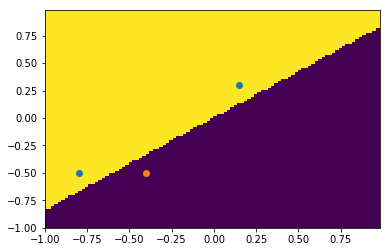

In [17]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [18]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

##### Check condtions are met

In [9]:
margin_constraint(flatten(w_0, a_0), x, y, m, d)

array([-1.78597244,  0.69064714, -2.1663206 ])

In [10]:
margin_constraint(flatten(w_opt_L1, a_opt_L1), x, y, m, d)

array([ 2.38017526e-08, -1.89605068e-07, -4.99619861e-07])

### Create Symmetric Initialization

In [31]:
alpha=100

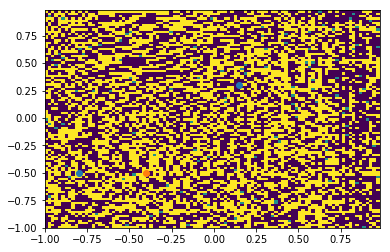

In [32]:
w_0, a_0 = symmetric_init(alpha=alpha, m=20, d=3)
plot_classifier(w_0, a_0, x, y)

### Find NTK solution

In [24]:
step_size = 0.1
epoch = 0
n_epochs = 1000

In [25]:
w_opt_ntk, a_opt_ntk = np.array(w_0), np.array(a_0)

for epoch in range(n_epochs):
    w_opt_ntk, a_opt_ntk, gamma_tilde, gamma = update_ntk(w_opt_ntk, a_opt_ntk, w_0, a_0, x, y, epoch, step_size)  

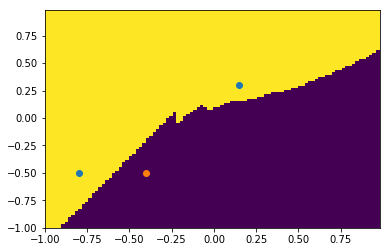

In [27]:
plot_classifier_ntk(w_opt_ntk, a_opt_ntk, w_0, a_0, x, y)

### Train Full Model

In [2242]:
def solve_Q(mu, x, y, w_0, a_0, m, d):
    w_opt_Q, a_opt_Q = Q_solver(mu , x, y, w_0, a_0, m, d, obj='Q')
    _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x, y, epoch)
    
    w_tilde_norms = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma
    excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
    #excess_l1 = np.linalg.norm(flatten(w_opt_Q, a_opt_Q), ord=2) / np.linalg.norm(flatten(w_opt_L1, a_opt_L1), ord=2) / gamma**0.5 - 1
    return excess_l1

In [28]:
step_size = 0.1
epoch = 0
n_epochs = 10000

In [38]:
training_accuracy = []
excess_l1_curve = []
consine_sim_ntk = []

training_accuracy_Q = []
excess_l1_Q_curve = []

w, a = np.array(w_0), np.array(a_0)

for epoch in range(n_epochs):
    w, a, gamma_tilde, gamma = update(w, a, x, y, epoch, step_size)
    
    w_tilde_norms = calc_w_tilde_norms(w, a) / gamma
    excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
    training_accuracy.append(gamma_tilde)
    excess_l1_curve.append(excess_l1)
    
    w_tilde_norms_ntk = calc_w_tilde_norms(w_opt_ntk, a_opt_ntk)
    consine_sim_ntk.append(cosine_sim(w_tilde_norms, w_tilde_norms_ntk))
    
    estimate_Q = False
    if (epoch + 1) % 1000 == 0:
        estimate_Q = True
    if (epoch < 100) and (gamma > 0) and ((epoch + 1) % 10 == 0):
        estimate_Q = True
    if estimate_Q:
        mu = [alpha**2/gamma_tilde] * m
        w_opt_Q, a_opt_Q = solver(x, y, w_0, a_0, m, d, obj='Q', mu=mu)
        _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x, y, epoch, 0)
        w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma
        
        excess_l1_Q = np.linalg.norm(w_tilde_norms_Q, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        excess_l1_Q_curve.append(excess_l1_Q)
        training_accuracy_Q.append(gamma_tilde)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -441.8668880233405
            Iterations: 8
            Function evaluations: 657
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -46.354729378661744
            Iterations: 9
            Function evaluations: 740
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -27.976097204301965
            Iterations: 11
            Function evaluations: 904
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -21.386170491992925
            Iterations: 12
            Function evaluations: 985
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.342862860645138
            Iterations: 12
            Fun

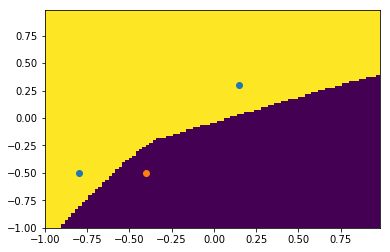

In [39]:
plot_classifier(w, a, x, y)

In [40]:
gamma_tilde

1327108.5144458874

/Users/shaharazulay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  
/Users/shaharazulay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


Text(0.5, 0, 'Training Accuracy')

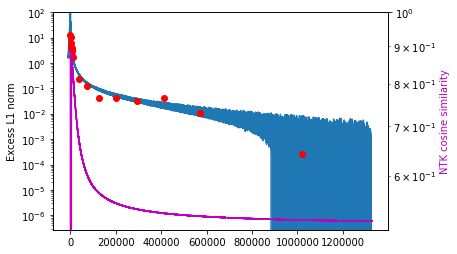

In [45]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('Excess L1 norm', color='k')
ax1.plot(training_accuracy, excess_l1_curve)
ax1.plot(training_accuracy_Q, excess_l1_Q_curve, 'ro')
ax1.set_yscale('log')
ax1.set_ylim([0, 100]);

ax2 = ax1.twinx()
ax2.set_ylabel('NTK cosine similarity', color='m')
ax2.plot(training_accuracy, consine_sim_ntk, 'm')
ax2.set_yscale('log')
ax2.set_ylim([0, 1]);

xlabel('Training Accuracy')

In [46]:
min_mu = min([alpha**2/t for t in training_accuracy_Q])
max_mu = max([alpha**2/t for t in training_accuracy_Q])

min_mu, max_mu

(0.0075351788426851725, 44.18668880233938)

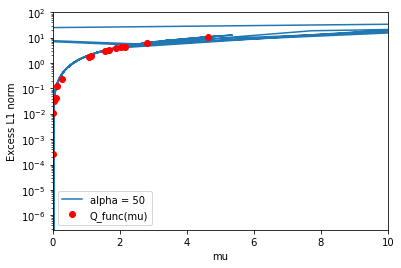

In [48]:
plot([alpha**2/t for t in training_accuracy], excess_l1_curve)
plot([alpha**2/t for t in training_accuracy_Q], excess_l1_Q_curve, 'ro')

ylabel('Excess L1 norm')
yscale('log')
ylim([0, 100])
xlim([0, 10])
xlabel('mu')
legend(['alpha = 50', 'Q_func(mu)'])